# Implementing BERT

## Data pre-processing
Here we are going to tokenize and pad the filings to meet the BERT sequence length requirements. 

Important choices:
* Sequence length
* How to adapt BERT for document classification

In [ ]:
pip install tf-models-official==2.4.0

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz


import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt


In [ ]:
#import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using CPU')
  device = torch.device("cpu")

There are 1 GPU(s) available
We will use the GPU: Tesla K80


In [ ]:
data = pd.read_csv('/content/consolidated-data')
data.head()

,Unnamed: 0,CIK Code,Filing,Date Filed_x,Ticker,CompanyName,Previous close,Next Open
0,0,1364954,An investment in our securities involves a hig...,2021-02-27,CHGG,"CHEGG, INC",96.529999,95.870003
1,1,1738758,An investment in our securitiesis speculative ...,2020-09-14,GSMG,GLORY STAR NEW MEDIA GROUP HOLDINGS Ltd,3.010000,3.000000
2,2,1738758,An investment in our securitiesis speculative ...,2020-09-14,GSMG,GLORY STAR NEW MEDIA GROUP HOLDINGS Ltd,3.420000,3.600000
3,3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",30.250000,30.610001
4,4,1422892,Beforeyou make a decision to invest in our sec...,2018-02-16,SINO,"Sino-Global Shipping America, Ltd.",2.020000,2.080000


In [ ]:
labels = []

for i in range(len(data)):
  if data['Next Open'][i] > data['Previous close'][i]:
    labels.append(1)
  else:
    labels.append(0)

In [ ]:
data.insert(8, 'Label', labels)
data.head()

,Unnamed: 0,CIK Code,Filing,Date Filed_x,Ticker,CompanyName,Previous close,Next Open,Label
0,0,1364954,An investment in our securities involves a hig...,2021-02-27,CHGG,"CHEGG, INC",96.529999,95.870003,0
1,1,1738758,An investment in our securitiesis speculative ...,2020-09-14,GSMG,GLORY STAR NEW MEDIA GROUP HOLDINGS Ltd,3.010000,3.000000,0
2,2,1738758,An investment in our securitiesis speculative ...,2020-09-14,GSMG,GLORY STAR NEW MEDIA GROUP HOLDINGS Ltd,3.420000,3.600000,1
3,3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",30.250000,30.610001,1
4,4,1422892,Beforeyou make a decision to invest in our sec...,2018-02-16,SINO,"Sino-Global Shipping America, Ltd.",2.020000,2.080000,1


In [ ]:
data.drop(columns='Unnamed: 0', inplace = True)
data.head()

,CIK Code,Filing,Date Filed_x,Ticker,CompanyName,Previous close,Next Open,Label
0,1364954,An investment in our securities involves a hig...,2021-02-27,CHGG,"CHEGG, INC",96.529999,95.870003,0
1,1738758,An investment in our securitiesis speculative ...,2020-09-14,GSMG,GLORY STAR NEW MEDIA GROUP HOLDINGS Ltd,3.010000,3.000000,0
2,1738758,An investment in our securitiesis speculative ...,2020-09-14,GSMG,GLORY STAR NEW MEDIA GROUP HOLDINGS Ltd,3.420000,3.600000,1
3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",30.250000,30.610001,1
4,1422892,Beforeyou make a decision to invest in our sec...,2018-02-16,SINO,"Sino-Global Shipping America, Ltd.",2.020000,2.080000,1


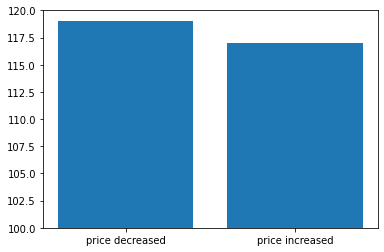

Price increased: 117
Price decreased: 119


In [ ]:
incr_counts = 0

for i in data.Label:
  incr_counts += i

decr_counts = len(data) - incr_counts

counts = [decr_counts, incr_counts]
labels = ['price decreased', 'price increased']
plt.bar(labels, counts)
plt.ylim([100, 120])
plt.show()

print('Price increased: {}'.format(incr_counts))
print('Price decreased: {}'.format(decr_counts))


## Train/test split

In [ ]:
x = data.Filing.values
y = data.Label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 32)

## Tokenization
The functions used will be from the official.nlp.bert package.

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def encode(n):
  tokens = list(tokenizer.tokenize(n))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

filings = tf.ragged.constant([encode(n) for n in x_train])

Let's take a look at what the tokenizer does to a filing.

In [ ]:
x_train[0]

"Investing in the Series 2021A Senior Notes involves risk. Please see the risk factors in The Southern Company’s Annual Report on Form 10-K for the year ended December 31, 2020 (the “Form 10-K”), which is incorporated by reference in this Prospectus Supplement and the accompanying Prospectus. Before making an investment decision, you should carefully consider these risks as well as other information contained or incorporated by reference in this Prospectus Supplement and the accompanying Prospectus. THE COMPANYThe Southern Company (the “Company”) was incorporated under the laws of Delaware on November 9, 1945. The principal executive offices of the Company are located at 30 Ivan Allen Jr. Boulevard, N.W., Atlanta, Georgia 30308, and the telephone number is (404) 506-5000. The Company’s internet address is http://www.southerncompany.com. The information on the Company’s website is not incorporated by reference in this Prospectus Supplement and should not be considered to be a part of th

In [ ]:
tokenizedFile = tokenizer.tokenize(x_train[0])
for i in tokenizedFile:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Streaming output truncated to the last 5000 lines.
Company [11739]
[UNK] [100]
s [187]
sub [13987]
##sid [34396]
##iar [21501]
##ies [11624]
. [119]
In [10167]
addition [14763]
, [117]
the [10105]
Company [11739]
had [10374]
approximately [17384]
$ [109]
0 [121]
. [119]
6 [127]
billion [25848]
of [10108]
short [13716]
- [118]
term [13719]
notes [19899]
pay [16868]
##able [13096]
, [117]
all [10435]
of [10108]
which [10319]
was [10134]
short [13716]
- [118]
term [13719]
notes [19899]
pay [16868]
##able [13096]
of [10108]
the [10105]
Company [11739]
[UNK] [100]
s [187]
sub [13987]
##sid [34396]
##iar [21501]
##ies [11624]
. [119]
In [10167]
addition [14763]
, [117]
as [10146]
of [10108]
December [11288]
31 [10413]
, [117]
2020 [23607]
, [117]
the [10105]
Company [11739]
[UNK] [100]
s [187]
sub [13987]
##sid [34396]
##iar [21501]
##ies [11624]
had [10374]
approximately [17384]
$ [109]
0 [121]
. [119]
3 [124]
billion [25848]
of [10108]
preferred [60278]
stock [20511]
outstanding [53933]
. 

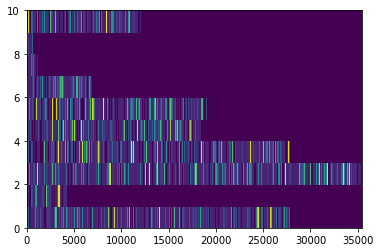

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*filings.shape[0]
input_word_ids = tf.concat([cls, filings], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

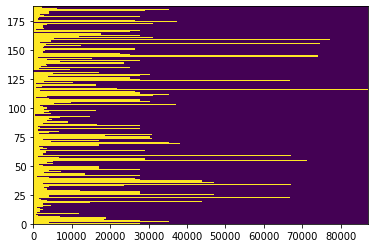

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

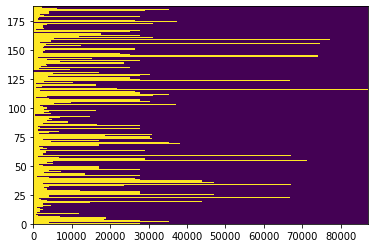

In [ ]:
type_cls = tf.zeros_like(cls)
type_filing = tf.ones_like(filings)
input_type_ids = tf.concat([type_cls, type_filing], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
input_type_ids

<tf.Tensor: shape=(188, 87177), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
lens = [len(i) for i in input_word_ids]
max_seq_length = max(lens)
print('Max sequence length is: {:,}'.format(max_seq_length))

Max sequence length is: 87,177


BERT is designed to have a maximum input length of 512 tokens, so we have to take a decision as for the sequence length we choose and the approach to adapt BERT for document classification. 

In [ ]:
MAX_LEN = 240

In [ ]:
def encode_files(n, tokenizer):
  tokens = list(tokenizer.tokenize(n))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, MAX_LEN):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_files(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, MAX_LEN))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, MAX_LEN))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, MAX_LEN)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
X_train = bert_encode(x_train, tokenizer, MAX_LEN)
X_test = bert_encode(x_test, tokenizer, MAX_LEN)

## Training

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
num_class = len(encoder.classes_) 
max_seq_length = MAX_LEN

def build_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

  output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

  output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)
  
  epochs = 3
  batch_size = 16  # select based on your GPU resources
  eval_batch_size = batch_size

  train_data_size = len(dummy_y_train)
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

  optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
  
  model.compile(optimizer = optimizer,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model

keras_model = build_model()

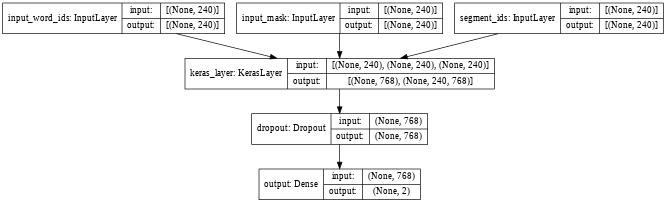

In [ ]:
tf.keras.utils.plot_model(keras_model, show_shapes=True, dpi=48)

In [ ]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
history = keras_model.fit(X_train,
                    dummy_y_train,
                    epochs = 3,
                    batch_size=16,
                    validation_data = (X_test, dummy_y_test),
                    verbose = 2)

Epoch 1/3
12/12 - 39s - loss: 0.6944 - accuracy: 0.5053 - val_loss: 0.7026 - val_accuracy: 0.5417
Epoch 2/3
12/12 - 20s - loss: 0.7229 - accuracy: 0.5266 - val_loss: 0.6870 - val_accuracy: 0.5417
Epoch 3/3
12/12 - 20s - loss: 0.6878 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5417


In [ ]:
loss, accuracy = keras_model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = keras_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5372
Testing Accuracy:  0.5417


In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

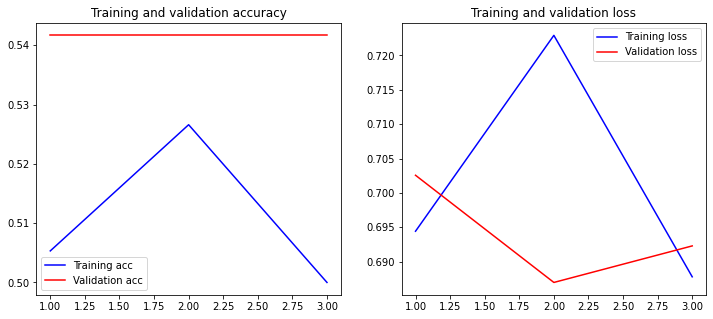

In [ ]:
plot_history(history)

In [ ]:
keras_model.predict(bert_encode(x_test, tokenizer, MAX_LEN), batch_size = 16, verbose=2)

3/3 - 1s


array([[0.5655595 , 0.4344405 ],
       [0.6015008 , 0.3984992 ],
       [0.5948664 , 0.4051336 ],
       [0.6233027 , 0.37669727],
       [0.5554605 , 0.44453952],
       [0.65444696, 0.345553  ],
       [0.56861895, 0.43138105],
       [0.6040309 , 0.3959691 ],
       [0.55307454, 0.44692546],
       [0.61129284, 0.38870716],
       [0.6410665 , 0.3589335 ],
       [0.6061874 , 0.39381257],
       [0.59954464, 0.40045536],
       [0.5444153 , 0.45558468],
       [0.55125254, 0.4487475 ],
       [0.5878854 , 0.41211468],
       [0.53023976, 0.4697603 ],
       [0.53023976, 0.4697603 ],
       [0.65444696, 0.345553  ],
       [0.56399256, 0.4360074 ],
       [0.61011213, 0.38988787],
       [0.51165575, 0.4883443 ],
       [0.5654727 , 0.43452728],
       [0.5628103 , 0.43718964],
       [0.55125254, 0.4487475 ],
       [0.62340075, 0.37659922],
       [0.6079783 , 0.39202175],
       [0.5751936 , 0.42480645],
       [0.6410665 , 0.3589335 ],
       [0.5796452 , 0.42035484],
       [0.